# Pregnancy Risk Prediction

In [36]:
import warnings
warnings.simplefilter(action="ignore")
warnings.filterwarnings("ignore")

from collections import Counter
from sklearn.utils import shuffle
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
import joblib

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Data Science My Repository/Projects/AI Health Guard Research /AI Health Guard Datasets/Pregnancy_Risk Data Set.csv")
df = shuffle(df, random_state=42)
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
752,29,130,70,7.7,98.0,78,mid risk
519,30,140,100,15.0,98.0,70,high risk
210,50,140,95,17.0,98.0,60,high risk
611,23,120,90,7.5,98.0,60,low risk
914,17,120,80,7.5,102.0,76,low risk


In [5]:
df.shape

(1014, 7)

In [6]:
# charactieristics of data
df.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
count,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000,1014.000000
mean,29.871795,113.198225,76.460552,8.725986,98.665089,74.301775
std,13.474386,18.403913,13.885796,3.293532,1.371384,8.088702
min,10.000000,70.000000,49.000000,6.000000,98.000000,7.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1014 entries, 752 to 102
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 63.4+ KB


In [8]:
# check null values
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

             count
Age              0
SystolicBP       0
DiastolicBP      0
BS               0
BodyTemp         0
HeartRate        0
RiskLevel        0


In [9]:
# Risklevel count
print(df["RiskLevel"].value_counts())

RiskLevel
low risk     406
mid risk     336
high risk    272
Name: count, dtype: int64


In [10]:
df.columns

Index(['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate',
       'RiskLevel'],
      dtype='object')

In [11]:
# Plot the distribution of Risk Levels
fig = px.histogram(df, x='RiskLevel', title='Distribution of Risk Levels', color=df.index)
fig.show()

In [12]:
# Plot the distribution of Age
fig = px.histogram(df, x='Age', nbins=20, title='Distribution of Age')
fig.show()

* `10 - 15` Age group count `54`
* `15 - 25` Age group count `404`
* `25 - 35` Age group count `238`
* `35 - 45` Age group count `135`
* `45 - 55` Age group count `101`
* `55 - 70` Age group count `81`

So, `15 - 25` age group person get maximun number of pregnancy.

In [13]:
# Scatter plot of SystolicBP vs DiastolicBP colored by RiskLevel
fig = px.scatter(df, x='SystolicBP', y='DiastolicBP', color='RiskLevel', title='SystolicBP vs DiastolicBP')
fig.show()

In [14]:
# Box plot of Blood Sugar (BS) by RiskLevel
fig = px.box(df, x='RiskLevel', y='BS', title='Blood Sugar Levels by Risk Level')
fig.show()

In [15]:
# Scatter plot of HeartRate vs BodyTemp colored by RiskLevel
fig = px.scatter(df, x='HeartRate', y='BodyTemp', color='RiskLevel', title='Heart Rate vs Body Temperature')
fig.show()

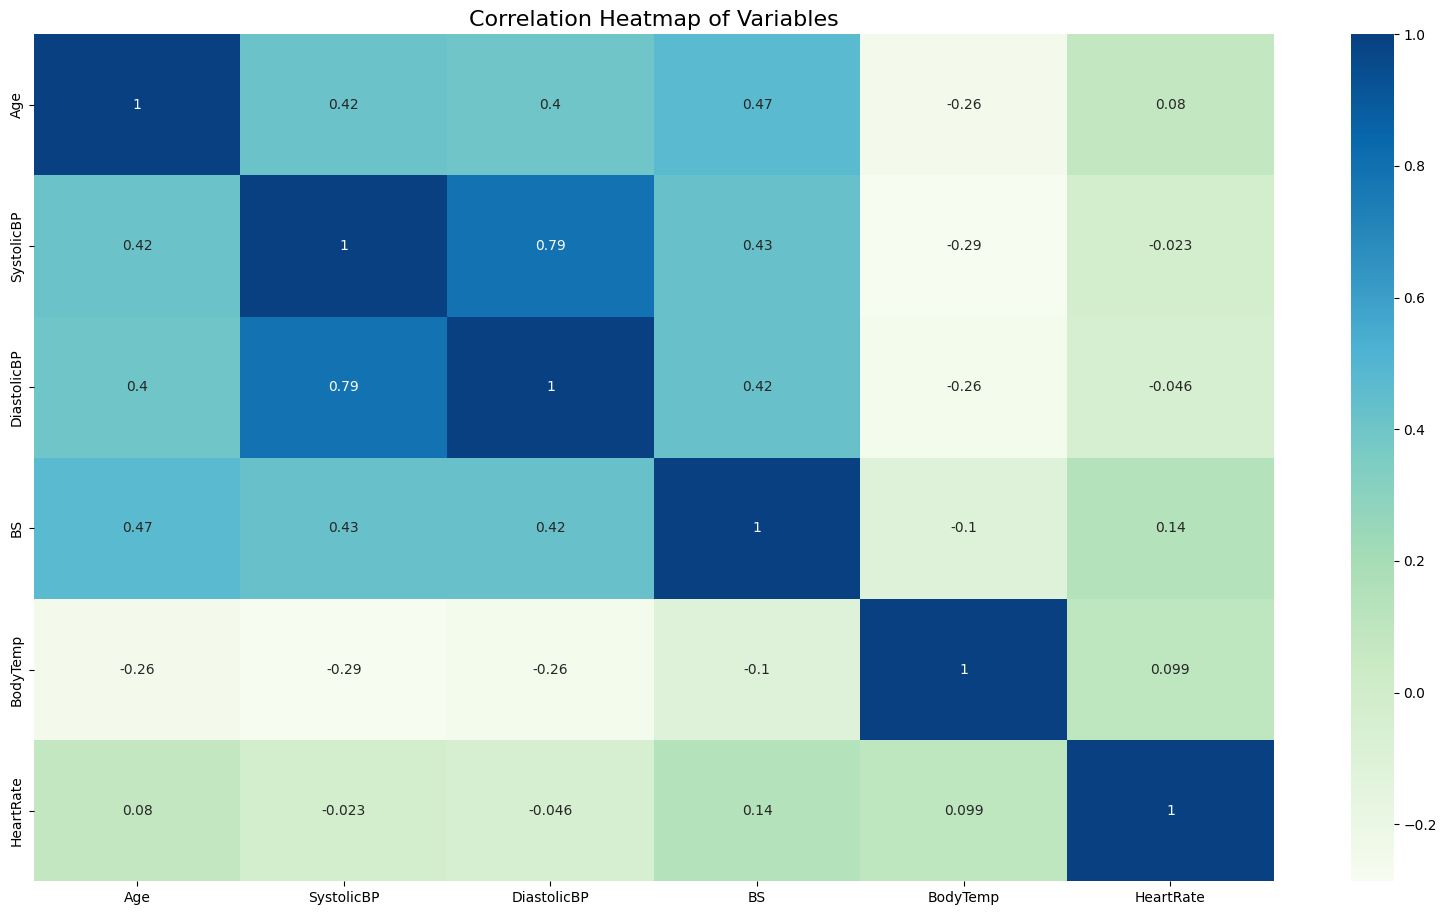

In [16]:
# Create a correlation heatmap
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(20,11))
sns.heatmap(numeric_df.corr(), annot=True, cmap = "GnBu")
plt.title("Correlation Heatmap of Variables", fontsize=16)
plt.show()

SystolicBP and DiastolicBP show a high positive correlation (correlation coefficient = 0.79), indicating multicollinearity. This suggests redundancy in information between these two variables.

In [17]:
# Dealing with multicollinearity
# Variance Inflation Factor (VIF) calculation
X = df[["SystolicBP", "DiastolicBP"]]
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_data

,Variable,VIF
0,SystolicBP,79.96833
1,DiastolicBP,79.96833


In [18]:
# Drop SystolicBP for model training
df = df.drop(["SystolicBP"], axis=1)

In [19]:
# Identify the outlier in HeartRate
df.HeartRate.sort_values().head()

908     7
499     7
774    60
602    60
410    60
Name: HeartRate, dtype: int64

In [20]:
# Remove the outlier in HeartRate
df = df.drop(df.index[df.HeartRate == 7])

In [21]:
df.head()

,Age,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
752,29,70,7.7,98.0,78,mid risk
519,30,100,15.0,98.0,70,high risk
210,50,95,17.0,98.0,60,high risk
611,23,90,7.5,98.0,60,low risk
914,17,80,7.5,102.0,76,low risk


In [22]:
df.shape

(1012, 6)

## Model Building

In [23]:
# Encode the target variable
label_encoder = LabelEncoder()
df['RiskLevel'] = label_encoder.fit_transform(df['RiskLevel'])

# Split the data into features and target variable
X = df.drop(columns=['RiskLevel'])
y = df['RiskLevel']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (809, 5)
Shape of X_test: (203, 5)
Shape of y_train: (809,)
Shape of y_test: (203,)


In [24]:
# Initialize the models
models = {
    'Gradient Boosting Classifier': GradientBoostingClassifier(),
    'KNeighbors Classifier': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC()
}

In [25]:
# Dictionary to store accuracies and confusion matrices
accuracies = {}

# Loop through the models, train, test, and store results
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Test the model
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[model_name] = accuracy

In [26]:
# Print accuracies
for model_name, accuracy in accuracies.items():
    print(f"{model_name} Accuracy: {accuracy}")

Gradient Boosting Classifier Accuracy: 0.7881773399014779
KNeighbors Classifier Accuracy: 0.6896551724137931
Logistic Regression Accuracy: 0.6157635467980296
Decision Tree Accuracy: 0.8029556650246306
Random Forest Accuracy: 0.812807881773399
SVM Accuracy: 0.5517241379310345


In [27]:
def get_metrics(y_test, y_pred):
    metrics = {}
    MSE = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(MSE)
    MAE = mean_absolute_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)

    metrics['MSE'] = MSE
    metrics['RMSE'] = RMSE
    metrics['MAE'] = MAE
    metrics['R2'] = R2

    return metrics
# Create an empty DataFrame to store metrics
metrics_df = pd.DataFrame(columns=['Model', 'MSE', 'RMSE', 'MAE', 'R2'])
# Iterate through each model in the dictionary
for model_name, model in models.items():
    metrics = get_metrics(y_test, y_pred)
    metrics['Model'] = model_name
    metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics, index=[0])], ignore_index=True)

# Print the DataFrame
print(metrics_df)

                          Model       MSE      RMSE      MAE        R2
0  Gradient Boosting Classifier  0.507389  0.712313  0.46798  0.187432
1         KNeighbors Classifier  0.507389  0.712313  0.46798  0.187432
2           Logistic Regression  0.507389  0.712313  0.46798  0.187432
3                 Decision Tree  0.507389  0.712313  0.46798  0.187432
4                 Random Forest  0.507389  0.712313  0.46798  0.187432
5                           SVM  0.507389  0.712313  0.46798  0.187432


## Hyperparameter Tuning

In [28]:
# Define the parameter grid for RandomForestClassifier
params_RF = {"min_samples_split": [2, 6, 20],
              "min_samples_leaf": [1, 2, 4],
              "n_estimators" :[50,100,200,300,400],
              "max_depth": [None, 10, 20, 30],
              "criterion": ["gini", "entropy"]
              }

# Initialize GridSearchCV
GridSearchCV_RF = GridSearchCV(estimator=RandomForestClassifier(), param_grid=params_RF, cv=3, scoring="accuracy", return_train_score=True)

# Fit the model
GridSearchCV_RF.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", GridSearchCV_RF.best_params_)

# Best estimator
RF_model = GridSearchCV_RF.best_estimator_

# Evaluate the best model
y_pred = RF_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best RandomForestClassifier Model after Hyperparameter Tuning:")
print(f"Accuracy: {accuracy}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")
# 7m

Best parameters found:  {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best RandomForestClassifier Model after Hyperparameter Tuning:
Accuracy: 0.8226600985221675
MSE: 0.3103448275862069
RMSE: 0.5570860145311556
MAE: 0.22167487684729065
R2 Score: 0.5029923830250271


In [31]:
# Define the parameter grid for GradientBoostingClassifier
params_GBC = {"loss": ["log_loss"],
              "learning_rate": [0.01, 0.05, 0.075, 0.1],
              "n_estimators": [100, 250, 500],
              "max_depth": [3, 5, 8, 10],
              "subsample": [0.8, 1],
              }

# Initialize GridSearchCV
GridSearchCV_GBC = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=params_GBC, cv=3, scoring="accuracy", return_train_score=True)

# Fit the model
GridSearchCV_GBC.fit(X_train, y_train)

# Best parameters
print("Best parameters found: ", GridSearchCV_GBC.best_params_)

# Best estimator
gbc_model = GridSearchCV_GBC.best_estimator_

# Evaluate the best model
y_pred = gbc_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Best GradientBoostingClassifier Model after Hyperparameter Tuning:")
print(f"Accuracy: {accuracy}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R2 Score: {r2}")
# 12 m

Best parameters found:  {'learning_rate': 0.1, 'loss': 'log_loss', 'max_depth': 8, 'n_estimators': 100, 'subsample': 1}
Best GradientBoostingClassifier Model after Hyperparameter Tuning:
Accuracy: 0.812807881773399
MSE: 0.32019704433497537
RMSE: 0.5658595623783125
MAE: 0.2315270935960591
R2 Score: 0.4872143634385201


In [32]:
# Create a DataFrame to store model evaluation results
results = pd.DataFrame({
    "Model": ["Gradient Boosting Classifier", "K-Nearest Neighbors", "Logistic Regression", "Decision Tree", "Random Forest", "SVM"],
    "Train Score": [
        # Calculate mean cross-validated accuracy for training set
        cross_val_score(gbc_model, X_train, y_train, cv=3).mean(),
        cross_val_score(KNeighborsClassifier().fit(X_train, y_train), X_train, y_train, cv=3).mean(),
        cross_val_score(LogisticRegression().fit(X_train, y_train), X_train, y_train, cv=3).mean(),
        cross_val_score(DecisionTreeClassifier().fit(X_train, y_train), X_train, y_train, cv=3).mean(),
        cross_val_score(RF_model, X_train, y_train, cv=3).mean(),
        cross_val_score(SVC().fit(X_train, y_train), X_train, y_train, cv=3).mean(),
    ],
    "Test Score": [
        # Calculate accuracy on the test set
        gbc_model.score(X_test, y_test),
        KNeighborsClassifier().fit(X_train, y_train).score(X_test, y_test),
        LogisticRegression().fit(X_train, y_train).score(X_test, y_test),
        DecisionTreeClassifier().fit(X_train, y_train).score(X_test, y_test),
        RF_model.score(X_test, y_test),
        SVC().fit(X_train, y_train).score(X_test, y_test),
    ]
})
# Additional Metrics (precision, recall, F1 score)
metrics = ["precision", "recall", "f1"]
# Fit models before calculating metrics
knn_model = KNeighborsClassifier().fit(X_train, y_train)
lr_model = LogisticRegression().fit(X_train, y_train)
dt_model = DecisionTreeClassifier().fit(X_train, y_train)
svm_model = SVC().fit(X_train, y_train)

for metric in metrics:
    results[f"{metric.capitalize()}"] = [
        precision_recall_fscore_support(y_test, model.predict(X_test), average="weighted")[metrics.index(metric)]
        for model in [gbc_model, knn_model, lr_model, dt_model, RF_model, svm_model]
    ]

result_df = results.sort_values(by="Test Score", ascending=False)
result_df = result_df.set_index("Test Score")
result_df

,Model,Train Score,Precision,Recall,F1
Test Score,,,,,
0.822660,Random Forest,0.817110,0.834432,0.822660,0.825082
0.812808,Gradient Boosting Classifier,0.812167,0.827254,0.812808,0.814776
0.802956,Decision Tree,0.797324,0.809057,0.802956,0.803808
0.689655,K-Nearest Neighbors,0.644050,0.695131,0.689655,0.691531
0.561576,Logistic Regression,0.558741,0.530280,0.561576,0.504912
0.551724,SVM,0.557479,0.420213,0.551724,0.452321


## Model Saving and Predictions

In [37]:
# Save the best model
joblib.dump(RF_model, 'model.pkl')

# Load the model
loaded_model = joblib.load('model.pkl')

# Driver code for prediction
def predict_risk_level(age, diastolic_bp, bs, body_temp, heart_rate):
    data = np.array([[age, diastolic_bp, bs, body_temp, heart_rate]])
    prediction = loaded_model.predict(data)
    return label_encoder.inverse_transform(prediction)[0]

# Example prediction
print(predict_risk_level(29, 70, 7.7, 98.0, 78))

mid risk


In [38]:
# Example prediction
print(predict_risk_level(50, 90, 5.5, 108.0, 80))

low risk


In [39]:
# Example prediction
print(predict_risk_level(80, 120, 9.5, 80.0, 120))

high risk


In [40]:
import sklearn
print(sklearn.__version__)

1.5.0
